<a href="https://colab.research.google.com/github/vigneshvalliappan/DRLgames/blob/master/DRL_Space_Invaders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.15.0
6
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


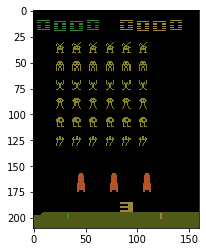

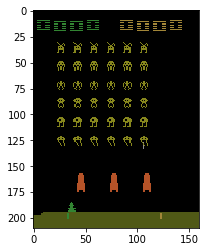

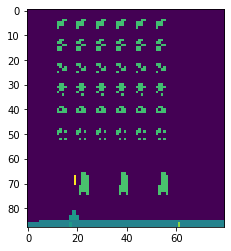

(210, 160, 3)
(88, 80)
Epochs per episode: 896 Episode Reward: 255.0 Episode number: 1
Epochs per episode: 919 Episode Reward: 315.0 Episode number: 2
Epochs per episode: 633 Episode Reward: 105.0 Episode number: 3
Epochs per episode: 685 Episode Reward: 210.0 Episode number: 4
Epochs per episode: 506 Episode Reward: 120.0 Episode number: 5
Epochs per episode: 570 Episode Reward: 75.0 Episode number: 6
Epochs per episode: 1035 Episode Reward: 175.0 Episode number: 7
Epochs per episode: 553 Episode Reward: 180.0 Episode number: 8
Epochs per episode: 397 Episode Reward: 125.0 Episode number: 9
Epochs per episode: 974 Episode Reward: 230.0 Episode number: 10
Epochs per episode: 559 Episode Reward: 50.0 Episode number: 11
Epochs per episode: 485 Episode Reward: 45.0 Episode number: 12
Epochs per episode: 906 Episode Reward: 230.0 Episode number: 13
Epochs per episode: 650 Episode Reward: 145.0 Episode number: 14
Epochs per episode: 1310 Episode Reward: 355.0 Episode number: 15
Epochs per e

In [0]:
#All of this code is from: https://github.com/EXJUSTICE/Optimized_DQN_OpenAI_SpaceInvaders/blob/master/TF2_SpaceInvaders_GC.ipynb

import numpy as np
import gym
import tensorflow as tf
from tensorflow.contrib.layers import flatten, conv2d, fully_connected
from collections import deque, Counter
import random
from datetime import datetime

print(tf.__version__)

color = np.array([210, 164, 74]).mean()


#prepro (210, 160, 3) uint8 frame into 7040 (88x80) 1D float vector 

def preprocess_observation(obs):

    # Crop and resize the image
    img = obs[25:201:2, ::2]

    # Convert the image to greyscale
    img = img.mean(axis=2)

    # Improve image contrast
    img[img==color] = 0

    # Next we normalize the image from -1 to +1
    img = (img - 128) / 128 - 1

    return img.reshape(88,80)



env = gym.make("SpaceInvaders-v0")
n_outputs = env.action_space.n
print(n_outputs)
print(env.env.get_action_meanings())

observation = env.reset()

import tensorflow as tf
import matplotlib.pyplot as plt


for i in range(22):
  
  if i > 20:
    plt.imshow(observation)
    plt.show()

  observation, _, _, _ = env.step(1)


#Run this cell for more observations.
for i in range(22):
  
  if i > 20:
    plt.imshow(observation)
    plt.show()

  observation, _, _, _ = env.step(1)


#Take a look at the preprocessed inputs in greyscale
#Let's compare the original and preprocessed tensors.

obs_preprocessed = preprocess_observation(observation).reshape(88,80)
plt.imshow(obs_preprocessed)
plt.show()
print(observation.shape)
print(obs_preprocessed.shape)


#Frame Stacking, used to supply another minibatch within a minibatch, in order to judge motion. orginally in deepmind paper
#Basically, as long as we always use stacks for all steps, and are consistent, there will not be any significant gaps in frequency

"""
We have all these frames, but what gets fed as input to the “Q-Network”? Paper used
 a sequence of four game frames stacked together, making the data dimension (4,84,84). 
 The idea is that the action agents choose depends on the prior sequence of game frames. 
 Imagine playing Breakout, for instance. Is the ball moving up or down? 
 If the ball is moving down, you better get the paddle in position to bounce it back up. 
 If the thatball is moving up, you can wait a little longer or try to move in the opposite direction as needed if you think the ball will eventually reach there.

Due to the way that Atari renders screens, every other frame may not aactually be rendered.
This is negatively affecting our performance, so instead, we take Deepmind's approach of element wise maxima
Create stack of 4, with 2 images combined via elementwise-maxima

"""


stack_size = 4 # We stack 4 composite frames in total

# Initialize deque with zero-images one array for each image. Deque is a special kind of queue that deletes last entry when new entry comes in
stacked_frames  =  deque([np.zeros((88,80), dtype=np.int) for i in range(stack_size)], maxlen=4)

def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_observation(state)
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((88,80), dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        # Because we're in a new episode, copy the same frame 4x, apply elementwise maxima
        maxframe = np.maximum(frame,frame)
        stacked_frames.append(maxframe)
        stacked_frames.append(maxframe)
        stacked_frames.append(maxframe)
        stacked_frames.append(maxframe)
        
        
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)
        
    else:
        #Since deque append adds t right, we can fetch rightmost element
        maxframe=np.maximum(stacked_frames[-1],frame)
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(maxframe)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2) 
    
    return stacked_state, stacked_frames


tf.compat.v1.reset_default_graph()
#Reset is technically not necessary if variables done  in TF2
#https://github.com/ageron/tf2_course/issues/8

def q_network(X, name_scope):
    
    # Initialize layers
    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=2.0)

    with tf.compat.v1.variable_scope(name_scope) as scope: 


        # initialize the convolutional layers
        layer_1 = conv2d(X, num_outputs=32, kernel_size=(8,8), stride=4, padding='SAME', weights_initializer=initializer) 
        tf.compat.v1.summary.histogram('layer_1',layer_1)
        
        layer_2 = conv2d(layer_1, num_outputs=64, kernel_size=(4,4), stride=2, padding='SAME', weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_2',layer_2)
        
        layer_3 = conv2d(layer_2, num_outputs=64, kernel_size=(3,3), stride=1, padding='SAME', weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_3',layer_3)
        
        # Flatten the result of layer_3 before feeding to the fully connected layer
        flat = flatten(layer_3)
        # Insert fully connected layer
        fc = fully_connected(flat, num_outputs=128, weights_initializer=initializer)
        tf.compat.v1.summary.histogram('fc',fc)
        #Add final output layer
        output = fully_connected(fc, num_outputs=n_outputs, activation_fn=None, weights_initializer=initializer)
        tf.compat.v1.summary.histogram('output',output)
        

        # Vars will store the parameters of the network such as weights
        vars = {v.name[len(scope.name):]: v for v in tf.compat.v1.get_collection(key=tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)} 
        #Return both variables and outputs together
        return vars, output


epsilon = 0.5
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 500000

#
def epsilon_greedy(action, step):
    p = np.random.random(1).squeeze() #1D entries returned using squeeze
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps) #Decaying policy with more steps
    if p< epsilon:
        return np.random.randint(n_outputs)
    else:
        return action




buffer_len = 20000
#Buffer is made from a deque - double ended queue
exp_buffer = deque(maxlen=buffer_len)


def sample_memories(batch_size):
    perm_batch = np.random.permutation(len(exp_buffer))[:batch_size]
    mem = np.array(exp_buffer)[perm_batch]
    return mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]




num_episodes = 2000
batch_size = 48

input_shape = (None, 88, 80, 1)
#Recall shape is img.reshape(88,80,1)
learning_rate = 0.001
#Modified for composite stacked frames
X_shape = (None, 88, 80, 4)
discount_factor = 0.97

global_step = 0
copy_steps = 100
steps_train = 4
start_steps = 2000



logdir = 'logs'
tf.compat.v1.reset_default_graph()

# Now we define the placeholder for our input i.e game state
X = tf.compat.v1.placeholder(tf.float32, shape=X_shape)

# we define a boolean called in_training_model to toggle the training
in_training_mode = tf.compat.v1.placeholder(tf.bool)




# we build our Q network, which takes the input X and generates Q values for all the actions in the state
mainQ, mainQ_outputs = q_network(X, 'mainQ')

# similarly we build our target Q network
targetQ, targetQ_outputs = q_network(X, 'targetQ')




# define the placeholder for our action values

X_action = tf.compat.v1.placeholder(tf.int32, shape=(None,))
Q_action = tf.reduce_sum(input_tensor=targetQ_outputs * tf.one_hot(X_action, n_outputs), axis=-1, keepdims=True)





copy_op = [tf.compat.v1.assign(main_name, targetQ[var_name]) for var_name, main_name in mainQ.items()]
copy_target_to_main = tf.group(*copy_op)



# define a placeholder for our output i.e action
y = tf.compat.v1.placeholder(tf.float32, shape=(None,1))

# now we calculate the loss which is the difference between actual value and predicted value
loss = tf.reduce_mean(input_tensor=tf.square(y - Q_action))

# we use adam optimizer for minimizing the loss
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.compat.v1.global_variables_initializer()

loss_summary = tf.compat.v1.summary.scalar('LOSS', loss)
merge_summary = tf.compat.v1.summary.merge_all()
file_writer = tf.compat.v1.summary.FileWriter(logdir, tf.compat.v1.get_default_graph())

with tf.compat.v1.Session() as sess:
    init.run()
    
    # for each episode
    history = []
    for i in range(num_episodes):
        done = False
        obs = env.reset()
        epoch = 0
        episodic_reward = 0
        actions_counter = Counter() 
        episodic_loss = []
        #First step, begin stacking frames
        
        obs,stacked_frames= stack_frames(stacked_frames,obs,True)

        # while the state is not the terminal state
        while not done:

           #Data generation using the untrained network
        
            

            # feed the game screen and get the Q values for each action,  FEED THE NETWORK BY CALLING THE OUTPUT LAYER
            
            actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode:False})

            # get the action
            action = np.argmax(actions, axis=-1)
            actions_counter[str(action)] += 1 

            # select the action using epsilon greedy policy
            action = epsilon_greedy(action, global_step)
            
            # now perform the action and move to the next state, next_obs, receive reward
            next_obs, reward, done, _ = env.step(action)

            #Begin stacking intra-episode code
            next_obs, stacked_frames = stack_frames(stacked_frames, next_obs, False)

            # Store this transistion as an experience in the replay buffer! Quite important
            exp_buffer.append([obs, action, next_obs, reward, done])
            
            # After certain steps, we train our Q network with samples from the experience replay buffer
            if global_step % steps_train == 0 and global_step > start_steps:
                #Our buffer should already contain everything preprocessed and stacked
                # sample experience, mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]
                o_obs, o_act, o_next_obs, o_rew, o_done = sample_memories(batch_size)

                # states
                o_obs = [x for x in o_obs]

                # next states
                o_next_obs = [x for x in o_next_obs]

                # next actions
                next_act = mainQ_outputs.eval(feed_dict={X:o_next_obs, in_training_mode:False})


                # discounted reward: these are our Y-values
                y_batch = o_rew + discount_factor * np.max(next_act, axis=-1) * (1-o_done) 

                # merge all summaries and write to the file
                mrg_summary = merge_summary.eval(feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:False})
                file_writer.add_summary(mrg_summary, global_step)

                # To calculate the loss, we run the previously defined functions mentioned while feeding inputs
                train_loss, _ = sess.run([loss, training_op], feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:True})
                episodic_loss.append(train_loss)
            
            # after some interval we copy our main Q network weights to target Q network
            if (global_step+1) % copy_steps == 0 and global_step > start_steps:
                copy_target_to_main.run()
                
            obs = next_obs
            epoch += 1
            global_step += 1
            episodic_reward += reward

        next_obs=np.zeros(obs.shape)
        exp_buffer.append([obs, action, next_obs, reward, done])
        obs= env.reset()
        obs,stacked_frames= stack_frames(stacked_frames,obs,True) 
        
        history.append(episodic_reward)
        print('Epochs per episode:', epoch, 'Episode Reward:', episodic_reward,"Episode number:", len(history))


plt.plot(history)
plt.show()